In [3]:
"""
* @ Author: Lucas Glasner (lgvivanco96@gmail.com)
* @ Create Time: 1969-12-31 21:00:00
* @ Modified by: Lucas Glasner,
* @ Modified time: 2024-01-19 15:43:04
* @ Description:
        Routines for the design of flood hydrographs based on synthetic
        hyetographs and unit hydrograph (SUH) methods.
*/
"""

My OS: posix


In [4]:
# --------------------------------- packages --------------------------------- #
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import scipy.signal as sg
from scipy.interpolate import interp1d
import xarray as xr
import os


In [5]:
# -------------------------- options and parameters -------------------------- #
# Rain
returnperiods_yr   = (2, 5, 10 , 25, 50 , 100, 200)
precips_mm24hr     = (52.2, 75.5, 90.9, 110.4, 124.9, 139.3, 153.6)
pr_security_factor = 1.0

# Basin props
basin_area_km2            = 91.8*0.9  # basin area
basin_meanslope_          = 0.144     # basin mean slope in m/m
basin_mriverlen_km        = 12.5      # Main channel distance
basin_out2centroid_km     = 6         # Distance from basin centroid to outlet
curve_number_             = 82        # dimensionless curve number (NORMAL)
moisture_condition_       = 'dry'     # 'dry', 'normal' or 'wet'

# Essential
tstep_hr       = 0.5           # Change this if the program raises error
shyeto_path    = 'data/shyeto.csv'
shyeto_name    = ['uniform','G1_Espildora','G2_Espildora','G3_Espildora']
SUHName        = 'Linsley'

# dump excel?
dhydro_dumpxls = False
dhydro_xlspath = 'EXAMPLE_dhydro.xlsx'

dhyeto_dumpxls = False
dhyeto_xlspath = 'EXAMPLE_dhyeto.xlsx'

suh_dumpxls    = False
suh_xlspath    = f'EXAMPLE_SUH.xlsx'

In [6]:
# ----------------------- duration coefficient routines ---------------------- #
def grunsky_coef(storm_duration, ref_duration=24):
    """
    This function computes the duration coefficient
    given by the Grunsky Formula.
    
    References: 
        ???

    Args:
        storm_duration (array_like): storm duration in (hours)
        ref_duration (array_like): Reference duration (hours).
            Defaults to 24 hr

    Returns:
        CD (array_like): Duration coefficient in (dimensionless)
    """
    CD = np.sqrt(storm_duration/ref_duration)
    return CD


def bell_coef(storm_duration, ref_duration=24):
    """
    This function computes the duration coefficient
    given by the Bell Formula.
    
    References: 
        Bell, F.C. (1969) Generalized Rainfall-Duration-Frequency
        Relationships. Journal of Hydraulic Division, ASCE, 95, 311-327.  

    Args:
        storm_duration (array_like): duration in (hours)

    Returns:
        CD (array_like): Duration coefficient in (dimensionless)
    """
    a    = (0.54*((storm_duration*60)**0.25)-0.5)
    b    = grunsky_coef(1, ref_duration)
    CD   = a*b
    return CD


def duration_coef(storm_duration,
                  ref_duration=24,
                  bell_threshold=1,
                  duration_threshold=10/60):
    """
    This function is a merge of Grunsky and Bell Formulations
    of the Duration Coefficient. The idea is to use Bell's 
    Formula only when the input duration is less than the "bell_threshold"
    parameter. In addition, when the duration is less than the
    "duration_threshold" the duration is set to the "duration_threshold".

    Args:
        storm_duration (array_like): Storm duration in hours
        bell_threshold (float, optional): Duration threshold for changing
            between Grunsky and Bell formulas. Defaults to 1 (hour).
        duration_threshold (float, optional): Minimum storm duration.
            Defaults to 10 minutes (1/6 hours). 

    Returns:
        coef (array_like): Duration coefficients (dimensionless)
    """
    def is_iterable(obj):
        """
        Simple function to check if an object
        is an iterable.

        Args:
            obj (any): Any python class

        Returns:
            (bool): True if iterable False if not
        """
        try:
            iter(obj)
            return True
        except TypeError:
            return False
    t = storm_duration
    if is_iterable(t):
        coefs = np.empty(len(t))
        for i in range(len(coefs)):
            if t[i]<duration_threshold:
                coefs[i] = duration_coef(duration_threshold, ref_duration)
            elif (t[i]>=duration_threshold) and (t[i]<bell_threshold):
                coefs[i] = bell_coef(t[i], ref_duration)
            else:
                coefs[i] = grunsky_coef(t[i], ref_duration)
    else:
        coefs = duration_coef([t], ref_duration, bell_threshold)
        coefs = coefs.item()
    return coefs

In [7]:
# --------------------------- inflitration routines -------------------------- #
def CN_correction(CN_II, AMC):
    """
    This function changes the curve number value according to antecedent
    moisture conditions (AMC)...

    Reference: 
        Ven Te Chow (1988), Applied Hydrology. MCGrow-Hill
        Soil Conservation Service, Urban hydrology for small watersheds,
        tech. re/. No. 55, U. S. Dept. of Agriculture, Washington, D.E:., 1975.

    Args:
        CN_II (float): curve number under normal condition
        AMC (str): Antecedent moisture condition.
            Options: 'dry', 'wet' or 'normal'

    Raises:
        RuntimeError: If AMC is different than 'dry', 'wet' or 'normal'

    Returns:
        CN_I or CN_III (float): _description_
    """
    if AMC=='dry':
        CN_I = 4.2*CN_II/(10-0.058*CN_II)
        return CN_I
    elif AMC=='normal':
        return CN_II
    elif AMC=='wet':
        CN_III = 23*CN_II/(10+0.13*CN_II)
        return CN_III
    else:
        text = f'AMC="{AMC}"'
        text = text+' Moisture condition can only be "dry, "neutral" or "wet"'
        raise RuntimeError(text)
    
def effective_rainfall(pr, duration, CN):
    S = (25400-254*CN)/CN
    pr_t = pr*duration_coef(duration)
    pr_eff = (pr_t-0.2*S)*(pr_t-0.2*S)/(pr_t+0.8*S)
    return pr_eff

def infiltration(pr, CN):
    S = (25400-254*CN)/CN
    if pr>0.2*S:
        a = 0.2*S
    else:
        a = pr
    if pr>=0.2*S:
        b = (S*(pr-0.2*S))/(pr+0.8*S)
    else:
        b = 0
    return a+b


In [8]:
# --------------------------- storm design routines -------------------------- #
def accumulated_unit_storms(storm_duration, tstep,
                            synth_hyeto_path,
                            **kwargs):
    SHyeto       = pd.read_csv(synth_hyeto_path, index_col=0)
    SHyeto_cum   = SHyeto.cumsum()
    SHyeto_names = SHyeto.columns
    
    storms       = SHyeto_cum.copy()
    storms.index = storms.index*storm_duration
    
    new_time    = np.arange(0, storm_duration+tstep,tstep)
    interpfuncs = [interp1d(storms.index, storms[c].values,
                            fill_value='extrapolate', **kwargs)
                   for c in SHyeto_names]
    storms      = [pd.Series(f(new_time), index=new_time, name=name) 
                   for f,name in zip(interpfuncs, SHyeto_names)]
    storms = [storm/storm.values[-1] for storm in storms] # Force accum(Pr) = 1
    storms = pd.concat(storms, axis=1)
    storms.index = np.round(storms.index,4)
    return storms

def design_storms(precips, storm_duration, tstep,
                  **kwargs):

    return_periods = precips.index
    u_storms       = accumulated_unit_storms(storm_duration, tstep,
                                             **kwargs)
    # rain_intensity = precips*duration_coef(storm_duration, ref_storm_duration)
    
    rainfall = pd.concat([precips]*len(u_storms.index),
                       keys=u_storms.index).swaplevel()
    rainfall = pd.concat([rainfall]*len(u_storms.columns),
                       keys=u_storms.columns).unstack(level=0)
    storms = pd.concat([rainfall.loc[T]*u_storms for T in return_periods],
                       keys=return_periods)
    
    storms = [storms.loc[T].diff(axis=0).bfill()
              for T in return_periods]
    storms = [s/s.sum()*rainfall.loc[T]
              for s,T in zip(storms, return_periods)]
    storms = pd.concat(storms, keys=precips.index).unstack(0)
    return storms

In [9]:
# ---------------- rainfall/runoff routines (unit hydrographs) --------------- #
def SUH_SCS(area_km2, mriverlen_km, meanslope_, curve_number_,
            tstep=0.1, kind='quadratic', **kwargs):
    """
    U.S.A Soil Conservation Service (SCS) synthetic unit hydrograph
    (dimensionless). 
    
    References:
        Bhunya, P. K., Panda, S. N., & Goel, M. K. (2011).
        Synthetic unit hydrograph methods: a critical review.
        The Open Hydrology Journal, 5(1).
        
        Chow Ven, T., Te, C. V., RC, M. D., & Mays, L. W. (1988).
        Applied hydrology. McGraw-Hill Book Company.
                
        Snyder, F. F., Synthetic unit-graphs, Trans. Am. Geophys. Union,
        vol. 19, pp. 447-454, 1938. Soil Conservation Service, Hydrology,
        sec. 4 del National Engineering Handhook. Soil Conservation Service,
        U. S. Department of Agriculture, Washington, D.C., 1972

        Snyder, F. F. (1938). Synthetic unit‐graphs. Eos,
        Transactions American Geophysical Union, 19(1), 447-454.
        
    Args:
        area_km2 (float): Basin area (km2)
        mriverlen_km (float): Main channel length (km)
        meanslope_ (float): Basin mean slope (m/m)
        curve_number_ (float): Basin curve number (dimensionless)
        tstep (float): Unit hydrograph discretization time step in hours. 
        kind (str): Specifies the kind of interpolation as a string or as
            an integer specifying the order of the spline interpolator to use.
            Defaults to 'quadratic'.
        **kwargs are passed to scipy.interpolation.interp1d function.
    
    Returns:
        uh, (qp, tp, tb, tstep) (tuple):
            (unit hydrograph),
            (Peak runoff (L/s/km2/mm), peak time (hours), base time (hours),
            time step (hours)))
        
    """
    def SCS_lagtime(L, CN, S):
        """
        This functions returns the lagtime of the SCS unit hydrograph.
        
        Args:
            L (float): Main channel length (km)
            CN (float): Curve number (dimensionless)
            S (float): Mean slope (m/m)
            
        Returns:
            lagtime (float): basin lagtime (hours)
        """
        a = (L*1e3)**0.8*(2540-22.86*CN)**0.7
        b = (14104*CN**0.7*S**0.5)
        lagtime = a/b
        return lagtime
    
    # Unit hydrograph shape
    t_shape = [np.arange(0,2+0.1,0.1),
               np.arange(2.2, 4+0.2,0.2),
               np.arange(4.5, 5+0.5,0.5)]
    t_shape = np.hstack(t_shape)

    q_shape = np.array(
            [0, 0.03, 0.1, 0.19, 0.31, 0.47, 0.66, 0.82, 0.93, 0.99, 1,
            0.99, 0.93, 0.86, 0.78, 0.68, 0.56, 0.46, 0.39, 0.33, 0.28,0.207,
            0.147, 0.107, 0.077, 0.055, 0.040, 0.029, 0.021, 0.015, 0.011,
            0.005, 0])
    # Unit hydrograph paremeters
    tL = SCS_lagtime(mriverlen_km, curve_number_, meanslope_)
    tp = tL+tstep/2
    tb = 2.67*tp
    qp = 0.208*area_km2/tp
    uh = pd.Series(qp*q_shape, index=t_shape*tp)
    
    # Interpolate to new time resolution
    ntime = np.arange(uh.index[0], uh.index[-1]+tstep, tstep)
    f = interp1d(uh.index, uh.values, kind=kind,
                 fill_value='extrapolate', **kwargs)
    uh = f(ntime)
    uh = pd.Series(uh, index=ntime)
    uh = uh.where(uh>0).fillna(0)
    
    # Ensure that the unit hydrograph acummulates a volume of 1mm
    volume = np.trapz(uh, uh.index*3600)/1e6/A*1e3
    uh = uh/volume
    params = (qp, tp, tb, tstep)
    return uh, params

def SUH_Linsley(area_km2, mriverlen_km, out2centroid_km, meanslope_,
                zone, tstep, kind='quadratic', **kwargs):
    """
    Arteaga & Benitez Synthetic Unit Hydrograph, using Linsley formulas. 
    
    Linsley unit hydrograph (UH) is a similar formulation of the well known
    Snyder UH. The difference is that Linsley's UH uses a different formula
    for the peak flow like this: 
    
        tp = Ct * (L * Lg / sqrt(S)) ^ nt
        qp = Cp * tp ^ np
        tb = Cb * tp ^ nb
        
    Where L, Lg and S are the following geomorphological properties:
    basin main channel length, distance between the basin outlet and centroid,
    and basin mean slope. 
    
    Ct, nt are shape parameters for the peak time, 
    Cp, np are shape parameters for the peak flow,
    Cb, nb are shape parameters for the base flow
        
    *** Shape paremeters probably depend on hydrological soil properties and
    land cover use. ¿? Maybe exists a better method in 2024 ¿? 
    
    References:
        Manual de calculo de crecidas y caudales minimos en cuencas sin 
        informacion fluviometrica. Republica de Chile, Ministerio de Obras
        Publicas (MOP), Dirección General de Aguas (DGA) (1995). 
        
        Metodo para la determinación de los hidrogramas sintéticos en Chile, 
        Arteaga F., Benitez A., División de Estudios Hidrológicos, 
        Empresa Nacional de Electricidad S.A (1985).
            
    Args:
        area_km2 (float): Basin area (km2)
        mriverlen_km (float): Main channel length (km)
        out2centroid_km (float): Distance from basin outlet to basin centroid (km)
        meanslope_ (float): Basin mean slope (m/m)
        zone (str): "I", "II", "III", "IV".
            Where Type IV for the deep Atacama Desert, 
                  Type I for Semi-arid Chile
                  Type II for Central Chile (Maule)
                  Type III for Southern Chile 
        tstep (float): Unit hydrograph target unitary time (tu) in hours. 
        kind (str): Specifies the kind of interpolation as a string or as
            an integer specifying the order of the spline interpolator to use.
            Defaults to 'quadratic'.
        **kwargs are passed to scipy.interpolation.interp1d function.
    
    Returns:
        uh, (qpR, tpR, tbR, tuR) (tuple):
            (unit hydrograph),
            (Peak runoff (L/s/km2/mm), peak time (hours), time step (hours)))
    """
    def SUH_ArteagaBenitez_Coefficients():
        """ 
        Returns:
            Linsley_parameters (pandas.DataFrame): 
                Parameters of the Linsley synthetic unit hydrograph
                for the different Chilean politital regions based on
                Arteaga & Benitez seminal work. 
        """
        Linsley_parameters = {
        'Ct':[0.323, 0.584,	1.351, 0.386],
        'nt':[0.422,	0.327, 0.237, 0.397],
        'Cp':[144.141, 522.514, 172.775, 355.2],
        'np':[-0.796, -1.511, -0.835, -1.22],
        'Cb':[5.377,	1.822,	5.428,	2.7],
        'nb':[0.805,	1.412,	0.717,	1.104]
        }
        Linsley_parameters = pd.DataFrame(Linsley_parameters,
                                        index=['I','II','III','IV'])
        return Linsley_parameters    
    
    def storm_duration_correction(tstep, tu):
        """
        This functions checks if the selected timestep can be used
        as the unit hydrograph time resolution (unitary time). 

        Args:
            tstep (float): Desired time step in hours
            tu (float): Raw unit hydrograph unitary time (tu) in hours. 

        Raises:
            RuntimeError: If selected tstep exceeds a 10% change of 
                unit hydrograph storm duration/unitary time. 

        Returns:
            float: Fixed timestep in hours
        """
        tR = np.round(tu/tstep)*tstep
        if ~((tR-tu)<0.1 and (tR-tu)>-0.1):
            raise RuntimeError(f'tu: {tR:.3f} - (tR-tu) exceeds 10%,\
                change tstep!')
        return tR
    
    coeffs = SUH_ArteagaBenitez_Coefficients().loc[zone]
    tp = coeffs['Ct']
    tp = tp * (mriverlen_km*out2centroid_km/np.sqrt(meanslope_))**coeffs['nt']
    tu = tp/5.5
    if tu>tstep*1.1:
        raise RuntimeError(f'tu = {tu:.3f} cant exceed 1.1 * (timestep)!!')
    
    # Adjust storm duration to the UH timestep
    tR  = storm_duration_correction(tstep,tu)
    tpR = tp+(tR-tu)/4
    qpR = coeffs['Cp']*tpR**(coeffs['np'])
    tbR = coeffs['Cb']*tpR**(coeffs['nb'])
    tuR = tR
    
    #Unit hydrograph shape
    t_shape = np.array([0,0.3,0.5,0.6,0.75,1,1.3,1.5,1.8,2.3,2.7,3])
    q_shape = np.array([0,0.2,0.4,0.6,0.80,1,0.8,0.6,0.4,0.2,0.1,0])
    
    # Compute unit hydrograph of duration equals tu
    uh  = np.array(q_shape)*qpR
    uh  = pd.Series(uh, index=np.array(t_shape)*tpR)
    
    # Interpolate to new time resolution
    ntime = np.arange(uh.index[0], uh.index[-1]+tuR, tuR)
    f = interp1d(uh.index, uh.values, kind=kind,
                 fill_value='extrapolate', **kwargs)
    uh = f(ntime)
    uh = pd.Series(uh, index=ntime)
    uh = uh.where(uh>0).fillna(0)
    
    # Ensure that the unit hydrograph acummulates a volume of 1mm
    volume = np.trapz(uh, uh.index*3600)/1e6 # mm
    uh = uh/volume
    params = (qpR/volume*area_km2/1e3, tpR, tbR, tuR)
    
    return uh*area_km2/1e3, params 

def UH_cumulative(UH, duration):
    tstep = np.diff(UH.index)[0]
    shifts = int(duration/tstep)
    n_repeats = int((len(UH)/shifts+1))
    sums   = [UH.shift(shifts*i) for i in range(n_repeats)]
    cumsum = pd.concat(sums,axis=1).sum(axis=1)/duration
    ntime  = np.arange(0, cumsum.index[-1]*2+tstep,tstep)
    cumsum = cumsum.reindex(ntime).ffill()
    return cumsum

In [10]:
# ------------------------ unit hydrograph computation ----------------------- #
if SUHName == 'Linsley':
    uh, uh_params = SUH_Linsley(basin_area_km2, basin_mriverlen_km,
                                basin_out2centroid_km, basin_meanslope_,
                                zone='I',
                                kind='quadratic',
                                tstep=tstep_hr)
elif SUHName == 'SCS':
    uh, uh_params = SUH_SCS(basin_area_km2, basin_mriverlen_km,
                            basin_meanslope_, curve_number_,
                            kind='quadratic',
                            tstep=tstep_hr)
else:
    raise TypeError(f"SUHName = '{SUHName}' can only be 'SCS' or 'Linsley' (for now)")
uh.name = f'{SUHName}_m3s*mm-1'
# Update timestep
tstep = uh_params[-1]

In [11]:
# -- compute eff precipitation hyetograph and convolve with unit hydrograph -- #
curve_number_ = CN_correction(curve_number_, moisture_condition_)
precips = pd.Series(precips_mm24hr, index=returnperiods_yr)*pr_security_factor
dhydro = [] 
dhyeto = []
for storm_duration in np.arange(1,24+1,1):
    precips_eff   = effective_rainfall(precips, storm_duration, curve_number_)
    storms     = design_storms(precips, storm_duration, tstep_hr,
                               synth_hyeto_path=shyeto_path)
    effstorms  = (storms.cumsum()*duration_coef(storm_duration))[shyeto_name]
    effstorms  = effstorms.map(lambda x: x-infiltration(x,curve_number_))
    effstorms  = effstorms.diff().fillna(0)

    # dhyeto.append(effstorms.to_xarray().rename({'index':'time'}))
    hyetographs,hydrographs = [],[]
    for i,N in enumerate(effstorms.columns.get_level_values(0).unique()):
        h1,h2 = [],[]
        for j,T in enumerate(effstorms.columns.get_level_values(1).unique()):
            rain  = effstorms[(N,T)]
            hydro = pd.Series(sg.convolve(rain, uh))
            h1.append(rain.to_xarray().rename({'index':'time'}))
            h2.append(hydro.to_xarray().rename({'index':'time'}))
            
        h1 = xr.concat(h1, 'return_period')
        h1.coords['return_period'] = precips.index
        hyetographs.append(h1)
        
        h2 = xr.concat(h2, 'return_period')
        h2.coords['return_period'] = precips.index
        hydrographs.append(h2)
       
    hyetographs = xr.concat(hyetographs, 'shyeto')
    hyetographs.coords['shyeto'] = effstorms.columns.get_level_values(0).unique()
    dhyeto.append(hyetographs)
     
    hydrographs = xr.concat(hydrographs, 'shyeto')
    hydrographs.coords['shyeto'] = effstorms.columns.get_level_values(0).unique()
    dhydro.append(hydrographs)
del hydrographs, hydro, h2
del precips_eff, storms, effstorms, hyetographs, rain, h1
del i,N,j,T

dhyeto = xr.concat(dhyeto, 'storm_duration')
dhyeto.coords['storm_duration'] = np.arange(1,24+1,1)
dhyeto = dhyeto.fillna(0).to_dataset(name='dhyeto')    
dhyeto = dhyeto['dhyeto']#.drop_indexes(dhyeto.coords)

dhydro = xr.concat(dhydro, 'storm_duration')
dhydro = dhydro.fillna(0).to_dataset(name='dhydro')
dhydro.coords['storm_duration'] = np.arange(1,24+1,1)
dhydro.coords['time'] = dhydro.coords['time']*tstep_hr
dhydro = dhydro['dhydro']#.drop_indexes(dhydro.coords)

In [12]:
# ----------------------------- dump spreadsheets ---------------------------- #
if dhydro_dumpxls:
    dhydro.to_dataframe().unstack().T.to_excel(dhydro_xlspath)
if dhyeto_dumpxls:
    dhyeto.to_dataframe().unstack().T.to_excel(dhyeto_xlspath)
if suh_dumpxls:
    uh.to_excel(suh_xlspath)

UH params [qp, tp, tb, tstep]: (6.104387237608026, 2.994858628433181, 13.002383740532757, 0.5)


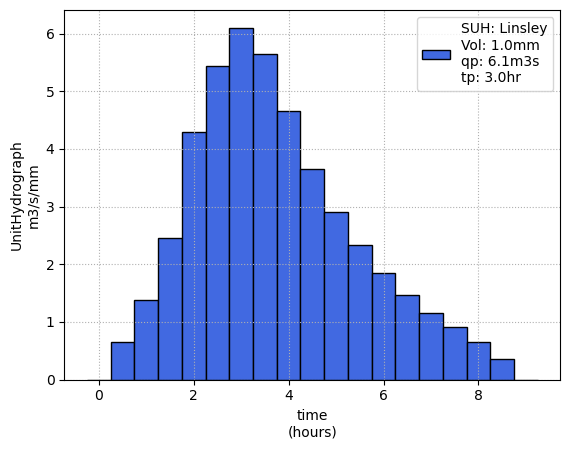

In [13]:
# ----------------------------------- plot1 ---------------------------------- #
plt.xlabel('time\n(hours)')
plt.ylabel('UnitHydrograph\nm3/s/mm')
plt.grid(True, ls=":")
plt.bar(
    uh.index, uh,
    width=tstep,
    color='royalblue',
    ec='k',
    label=f'\
SUH: {SUHName}\n\
Vol: {np.trapz(uh, uh.index*3600)/basin_area_km2/1e3:.1f}mm\n\
qp: {uh.max():.1f}m3s\n\
tp: {uh.idxmax():.1f}hr'
)
plt.legend()
print('UH params [qp, tp, tb, tstep]:', uh_params)

Text(0.01, 0.85, 'T =  100 yrs\nCN = 65.68\nAMC="dry"')

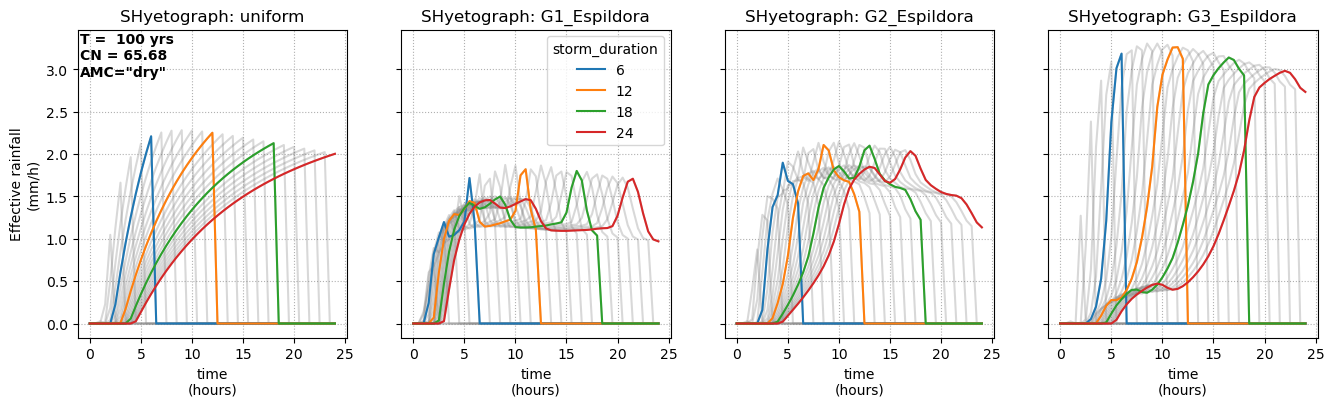

In [15]:
# ----------------------------------- plot2 ---------------------------------- #
Tyrs   = 100
storms = dhyeto.sel(return_period=Tyrs)
figsize = plt.figaspect(1/len(storms.coords['shyeto']))
fig, ax = plt.subplots(1,len(storms.coords['shyeto']), sharey=True, sharex=True,
                       dpi=100, facecolor='w', figsize=figsize)
for i, shyeto, axis in zip(range(len(shyeto_name)),shyeto_name, ax.ravel()):
    axis.set_title(f'SHyetograph: {shyeto}')
    rain = storms.sel(shyeto=shyeto).to_dataframe()['dhyeto'].unstack().T
    rain.plot(ax=axis, legend=False, color='grey', alpha=0.3)
    if i==1:
        legend=True
    else:
        legend=False;
    rain[[6,12,18,24]].plot(ax=axis, legend=legend)
    axis.set_xlabel('time\n(hours)')
    axis.grid(True, ls=":")
    del rain
ax[0].set_ylabel('Effective rainfall\n(mm/h)')
ax[0].text(0.01,0.85, f'T =  {Tyrs} yrs\nCN = {curve_number_:.2f}\nAMC="{moisture_condition_}"',
           transform=ax[0].transAxes, weight='bold')        

Text(0.01, 0.8, 'UH: Linsley\nT =  100 yrs\nCN = 65.7\nAMC="dry"')

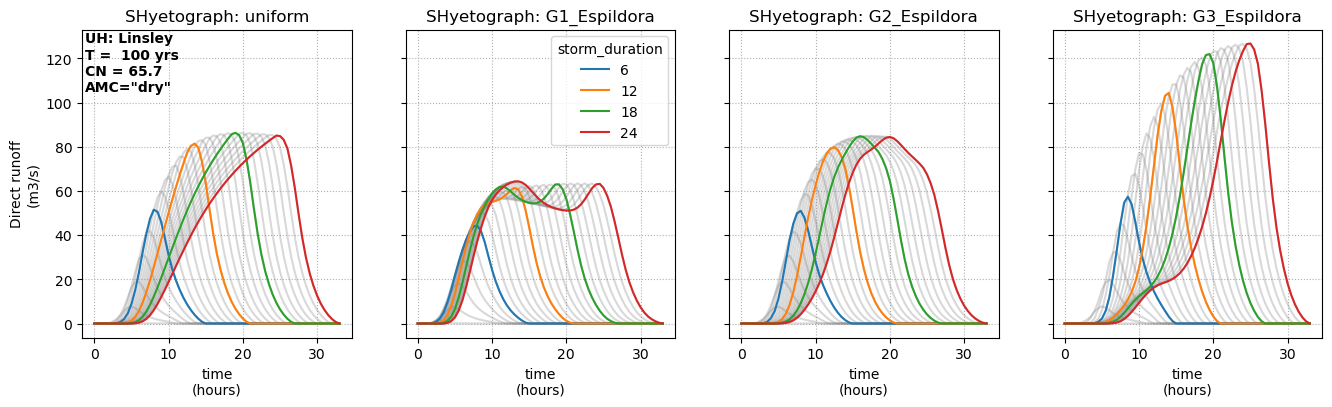

In [16]:
# ----------------------------------- plot3 ---------------------------------- #
Tyrs   = 100
flood = dhydro.sel(return_period=Tyrs)
figsize = plt.figaspect(1/len(flood.coords['shyeto']))
fig, ax = plt.subplots(1,len(flood.coords['shyeto']), sharey=True, sharex=True,
                       dpi=100, facecolor='w', figsize=figsize)
for i, shyeto, axis in zip(range(len(shyeto_name)),shyeto_name, ax.ravel()):
    axis.set_title(f'SHyetograph: {shyeto}')
    streamflow = flood.sel(shyeto=shyeto).to_dataframe()['dhydro'].unstack().T
    streamflow.plot(ax=axis, legend=False, color='grey', alpha=0.3)
    if i==1:
        legend=True
    else:
        legend=False;
    streamflow[[6,12,18,24]].plot(ax=axis, legend=legend) 
    axis.set_xlabel('time\n(hours)')
    axis.grid(True, ls=":")
    del streamflow
ax[0].set_ylabel('Direct runoff\n(m3/s)')
ax[0].text(0.01,0.8,
           f'UH: {SUHName}\nT =  {Tyrs} yrs\nCN = {curve_number_:.1f}\nAMC="{moisture_condition_}"',
           transform=ax[0].transAxes, weight='bold')

Text(0, -0.25, 'UH: Linsley - CN: 65.7 - AMC="dry"')

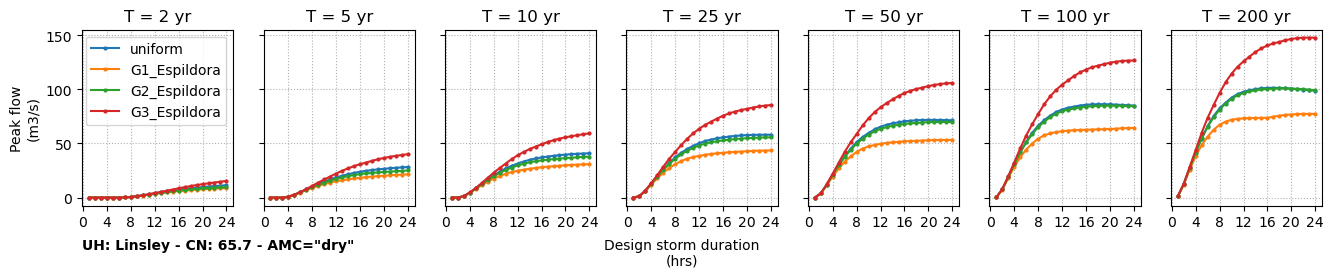

In [17]:
# ----------------------------------- plot4 ---------------------------------- #
peakrunoff = dhydro.max('time')
figsize = plt.figaspect(1/len(returnperiods_yr))
fig, ax = plt.subplots(1,len(returnperiods_yr), sharey=True, sharex=True,
                       dpi=100, facecolor='w', figsize=figsize)
for T, axis in zip(returnperiods_yr, ax.ravel()):
    axis.set_title(f'T = {T} yr')
    qp = peakrunoff.sel(return_period=T)#.to_dataframe()
    qp.drop_vars('return_period').to_dataframe()['dhydro'].unstack().plot(
        ax=axis, legend=False, marker='o', markersize=2)
    axis.grid(True, ls=":")
    axis.set_xlabel('') 
    axis.set_xticks([0,4,8,12,16,20,24])
    del qp
fig.text(0.5, -0.15, 'Design storm duration\n(hrs)', ha='center')
ax[0].set_ylabel('Peak flow\n(m3/s)')
ax[0].legend()
ax[0].text(0,-0.25, f'UH: {SUHName} - CN: {curve_number_:.1f} - AMC="{moisture_condition_}"',
           transform=ax[0].transAxes, weight='bold')